In [15]:
!python3 --version

Python 3.6.7


In [1]:
import multiprocessing as mp
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.callbacks import History, EarlyStopping, Callback
import tensorflow as tf
print(tf.version.VERSION)

2.6.2


In [17]:
test_list = [
	{'Course': "C++", 'Author': "Jerry"},
	{'Course': "Python", 'Author': "Mark"},
	{'Course': "Java", 'Author': "Paul"}]

res = list(filter(lambda test_list: test_list['Author'] == 'Jerry', test_list))
print(res[0]['Author'])



Jerry


In [19]:
class Parallel_Params:
    def __init__(self, config, i, chan_id, rid):
        self.config = config
        self.i = i
        self.chan_id = chan_id
        self.id =rid

In [20]:
l = []
for i in range(3):
    l.append(Parallel_Params("c", 1,i,2))

In [23]:
for i in iter(l):
    print(i)

In [4]:
os.chdir('telemanom')
os.getcwd()

'/users/juanjose/git/telemanom/telemanom'

In [5]:
from channel import Channel
from helpers import Config

In [6]:
cfg = Config("config.yaml")

In [9]:
ch = Channel(cfg, 'A-2')

In [10]:
ch.load_data()

[Errno 2] No such file or directory: 'data/train/A-2.npy'
Source data not found, may need to add data to repo: <link>


TypeError: object of type 'NoneType' has no len()

In [7]:
trn = np.load("../data/train/A-2.npy")

In [8]:
data = []
for i in range(len(trn) - cfg.l_s - cfg.n_predictions):
    data.append(trn[i:i + cfg.l_s + cfg.n_predictions])
data = np.array(data)

assert len(data.shape) == 3
np.random.shuffle(data)
X_train = data[:, :-cfg.n_predictions, :]
y_train = data[:, -cfg.n_predictions:, 0]  # telemetry value is at position 0

In [9]:
X_train.shape

(2388, 250, 25)

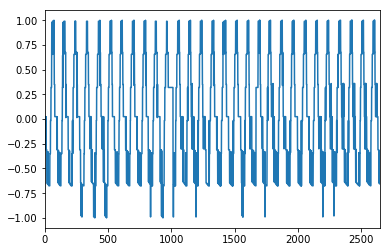

In [54]:
df[0].plot()

In [10]:
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, Flatten, RepeatVector
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential

In [68]:
model = Sequential()

model.add(LSTM(
    cfg.layers[0],
    input_shape=(None, trn.shape[1]),
    return_sequences=True))
model.add(Dropout(cfg.dropout))

model.add(LSTM(
    cfg.layers[1],
    return_sequences=False))
model.add(Dropout(cfg.dropout))

model.add(Dense(
    cfg.n_predictions))
model.add(Activation('linear'))

In [52]:
cfg.n_predictions

10

In [22]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(None, 25)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(Dropout(cfg.dropout))
model_enc_dec_cnn.add(Dense(
    25))
model_enc_dec_cnn.add(LSTM(
    cfg.layers[1],
    return_sequences=False))
model_enc_dec_cnn.add(Dropout(cfg.dropout))

model_enc_dec_cnn.add(Dense(
    cfg.n_predictions))
model_enc_dec_cnn.add(Activation('linear'))

In [24]:
cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=cfg.patience,
                                min_delta=cfg.min_delta,
                                verbose=0)]

In [ ]:
model_enc_dec_cnn.compile(loss=cfg.loss_metric,
                   optimizer=cfg.optimizer)

hist = model_enc_dec_cnn.fit(X_train,
               y_train,
               batch_size=cfg.lstm_batch_size,
               epochs=cfg.epochs,
               validation_split=cfg.validation_split,
               callbacks=cbs,
               verbose=True)

Epoch 1/35
30/30 [==============================] - 21s 606ms/step - loss: 0.1669 - val_loss: 0.0534
Epoch 2/35
30/30 [==============================] - 18s 587ms/step - loss: 0.0624 - val_loss: 0.0397
Epoch 3/35
30/30 [==============================] - 18s 589ms/step - loss: 0.0493 - val_loss: 0.0336
Epoch 4/35
30/30 [==============================] - 17s 582ms/step - loss: 0.0446 - val_loss: 0.0331
Epoch 5/35
30/30 [==============================] - 18s 589ms/step - loss: 0.0413 - val_loss: 0.0316
Epoch 6/35
30/30 [==============================] - 18s 589ms/step - loss: 0.0387 - val_loss: 0.0268
Epoch 7/35
30/30 [==============================] - 18s 592ms/step - loss: 0.0365 - val_loss: 0.0299
Epoch 8/35
30/30 [==============================] - 18s 591ms/step - loss: 0.0365 - val_loss: 0.0267
Epoch 9/35
30/30 [==============================] - 17s 582ms/step - loss: 0.0351 - val_loss: 0.0265
Epoch 10/35
30/30 [==============================] - 17s 583ms/step - loss: 0.0334 - val_lo